In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
# GENERAL UTILITIES
import os
from glob import glob
import pandas as pd
from  tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

# MODEL DEVELOPMENT DEPENDENCIES
import numpy as np
import pywt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [10]:
scaler_normalized = MinMaxScaler()
scaler_standardized = StandardScaler()
scaler = MinMaxScaler()

AUGMENT_CONSTANT = 0
DEBUG = False

In [11]:
def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values

#     labels[:,:2] = scaler_standardized.fit_transform(labels[:,:2])
#     labels[:,2:] = scaler_normalized.fit_transform(labels[:,2:])

    # labels = scaler_normalized.fit_transform(labels)

    return labels

def inverse_transform_labels(labels):

#     labels[:, :2] = scaler_standardized.inverse_transform(labels[:, :2])
#     labels[:, 2:] = scaler_normalized.inverse_transform(labels[:, 2:])

    labels = scaler_normalized.inverse_transform(labels)

    return labels

In [12]:

def load_data(directory: str, gt_file_path: str, is_train=True, augment_constant: int = 0):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
        gt_file_path (str): File path for the ground truth labels (expected CVS file)
        is_train (boolean): Binary flag for setting loader for Train (TRUE) or Test (FALSE)
        augment_constant (int): number of augmentation steps to randomly crop from the larger agricultural fields
    Returns:
        [type]: Tuple of lists composed of raw field (data , mask) pairs,
                and if exists: (augmented data, augmented mask) pairs, and ground truth labels
    """

    datalist = []
    masklist = []
    aug_datalist = []
    aug_masklist = []
    aug_labellist = []

    if is_train:
        labels = load_gt(gt_file_path)

    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )

    all_files = all_files[:600]

    if DEBUG:
        all_files = all_files[:100]
        if is_train:
            labels = labels[:100]

    for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading {} data .."
                               .format("training" if is_train else "test")):
       # We load the data into memory as provided in the example notebook of the challenge
        with np.load(file_name) as npz:
            mask = npz["mask"]
            data = npz["data"]
            datalist.append(data)
            masklist.append(mask)

    # for training data we make pre-augmentation by adding some randomly cropped samples
    if is_train:
        for i in range(augment_constant):
            for idx, file_name in tqdm(enumerate(all_files),total=len(all_files), desc="Loading augmentation {} ..".format(i+1)):
                # print(file_name)
                with np.load(file_name) as npz:
                    flag = True
                    mask = npz["mask"]
                    data = npz["data"]
                    ma = np.max(data, keepdims=False)
                    sh = data.shape[1:]
                    for i in range(10):
                        # Repeating 11x11 cropping 10 times does not mean we use all croppings:
                        # as seen in the Flag=False below at the end of the loop,
                        # when we reach at the good crop (not coinciding to the masked area) we stop searching

                        # Randomly cropping the fields with 11x11 size,
                        # and adding some noise to the cropped samples
                        edge = 11
                        x = np.random.randint(sh[0] + 1 - edge)
                        y = np.random.randint(sh[1] + 1 - edge)

                        # get crops having meaningful pixels, not zeros
                        if np.sum(mask[0, x : (x + edge), y : (y + edge)]) > 120:
                            aug_data = (data[:, x : (x + edge), y : (y + edge)]
                                        + np.random.uniform(-0.01, 0.01, (150, edge, edge)) * ma)
                            aug_mask = mask[:, x : (x + edge), y : (y + edge)] | np.random.randint(0, 1, (150, edge, edge))

                            flag = False #break the loop when you have a meaningful crop
                            break

                    # After having  11x11 croped sample, get another crop considering
                    # the minimum edge length: (min_edge,min_edge)
                    if flag:
                        max_edge = np.max(sh)
                        min_edge = np.min(sh)  # AUGMENT BY SHAPE
                        edge = min_edge  # np.random.randint(16, min_edge)
                        x = np.random.randint(sh[0] + 1 - edge)
                        y = np.random.randint(sh[1] + 1 - edge)
                        aug_data = (data[:, x : (x + edge), y : (y + edge)]
                                    + np.random.uniform(-0.001, 0.001, (150, edge, edge)) * ma)
                        aug_mask = mask[:, x : (x + edge), y : (y + edge)] | np.random.randint(0, 1, (150, edge, edge))

                    aug_datalist.append(aug_data)
                    aug_masklist.append(aug_mask)
                    aug_labellist.append(
                        labels[idx, :]
                        + labels[idx, :] * np.random.uniform(-0.001, 0.001, 4)
                    )

    # do pre-augmentation only for training data
    if is_train:
        return (datalist,
                masklist,
                labels,
                aug_datalist,
                aug_masklist,
                np.array(aug_labellist))
    else:
        return datalist, masklist



In [13]:

# Please be sure that the directory and file locations are given correctly in your own system
train_data_dir = "/content/drive/MyDrive/BTP/train_data/train_data/train_data"
test_data_dir = "/content/drive/MyDrive/BTP/test_data"
gt_data_path = "/content/drive/MyDrive/BTP/train_data/train_data/train_gt.csv"

# Loading training raw data
X_train, M_train, y_train, X_aug_train, M_aug_train, y_aug_train = load_data(train_data_dir,
                                                                             gt_data_path,
                                                                             is_train=True,
                                                                             augment_constant=AUGMENT_CONSTANT)


Loading training data ..:   0%|          | 0/600 [00:00<?, ?it/s]

In [14]:
def preprocess(data_list, mask_list, is_for_KNN=False):
    """Extract high-level features from the raw field data.

    Args:
        data_list: Directory to either train or test set
        mask_list: File path for the ground truth labels (expected CVS file)
        is_for_KNN: Binary flag for determining if the features are generated for KNN (TRUE) or Random Forest (FALSE)
    Returns:
        [type]: Tuple of lists composed of (features , field size) pairs for each field,
                where field size will be used performance analysis.
    """

    def _shape_pad(data):
        # This sub-function makes padding to have square fields sizes.
        # Not mandatory but eliminates the risk of calculation error in singular value decomposition,
        # padding by warping also improves the performance slightly.
        max_edge = np.max(image.shape[1:])
        shape = (max_edge, max_edge)
        padded = np.pad(data,((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),"wrap")
        return padded

    filtering = SpectralCurveFiltering()
    w1 = pywt.Wavelet("sym3")
    w2 = pywt.Wavelet("dmey")

    processed_data = []
    average_edge = []

    for idx, (data, mask) in enumerate(
        tqdm(
            zip(data_list, mask_list),
            total=len(data_list),
            position=0,
            leave=True,
            desc="INFO: Preprocessing data ...",
        )
    ):
        data = data / 2210   # max-max=5419 mean-max=2210
        m = 1 - mask.astype(int)
        image = data * m

        average_edge.append((image.shape[1] + image.shape[2]) / 2)
        image = _shape_pad(image)

        s = np.linalg.svd(image, full_matrices=False, compute_uv=False)
        s0 = s[:, 0]
        s1 = s[:, 1]
        s2 = s[:, 2]
        s3 = s[:, 3]
        s4 = s[:, 4]
        dXds1 = s0 / (s1 + np.finfo(float).eps)


        data = np.ma.MaskedArray(data, mask)
        arr = filtering(data)

        cA0, cD0 = pywt.dwt(arr, wavelet=w2, mode="constant")
        cAx, cDx = pywt.dwt(cA0[12:92], wavelet=w2, mode="constant")
        cAy, cDy = pywt.dwt(cAx[15:55], wavelet=w2, mode="constant")
        cAz, cDz = pywt.dwt(cAy[15:35], wavelet=w2, mode="constant")
        cAw2 = np.concatenate((cA0[12:92], cAx[15:55], cAy[15:35], cAz[15:25]), -1)
        cDw2 = np.concatenate((cD0[12:92], cDx[15:55], cDy[15:35], cDz[15:25]), -1)

        cA0, cD0 = pywt.dwt(arr, wavelet=w1, mode="constant")
        cAx, cDx = pywt.dwt(cA0[1:-1], wavelet=w1, mode="constant")
        cAy, cDy = pywt.dwt(cAx[1:-1], wavelet=w1, mode="constant")
        cAz, cDz = pywt.dwt(cAy[1:-1], wavelet=w1, mode="constant")
        cAw1 = np.concatenate((cA0, cAx, cAy, cAz), -1)
        cDw1 = np.concatenate((cD0, cDx, cDy, cDz), -1)

        dXdl = np.gradient(arr, axis=0)
        d2Xdl2 = np.gradient(dXdl, axis=0)
        d3Xdl3 = np.gradient(d2Xdl2, axis=0)


        fft = np.fft.fft(arr)
        real = np.real(fft)
        imag = np.imag(fft)
        ffts = np.fft.fft(s0)
        reals = np.real(ffts)
        imags = np.imag(ffts)

        # The best Feature combination for Random Forest based regression
        out_rf = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                dXds1,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,
                reals,
                imags,
                cAw1,
                cAw2,
            ],
            -1,
        )

        # The best Feature combination for KNN based regression
        out_knn = np.concatenate(
            [
                arr,
                dXdl,
                d2Xdl2,
                d3Xdl3,
                s0,
                s1,
                s2,
                s3,
                s4,
                real,
                imag,

            ],
            -1,
        )


        if is_for_KNN:
            processed_data.append(out_knn)
        else:
            processed_data.append(out_rf)

    return np.array(processed_data), np.array(average_edge)



class SpectralCurveFiltering: # Default class provided by the challenge organizers
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function=np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


In [15]:
X_tr_processed, avg_edge_train = preprocess(X_train, M_train)
X_aug_processed, avg_edge_train_aug = preprocess(X_aug_train, M_aug_train)

INFO: Preprocessing data ...:   0%|          | 0/600 [00:00<?, ?it/s]

INFO: Preprocessing data ...: 0it [00:00, ?it/s]

In [17]:
X_tr_processed = scaler.fit_transform(X_tr_processed)
# X_aug_processed = scaler.fit_transform(X_aug_processed)
# y = inverse_transform_labels(y)

indices = np.arange(600)
np.random.shuffle(indices)

In [18]:
len(X_tr_processed)

600

In [19]:
train_number = (int)(len(indices) * 0.8)
train_indices = indices[:train_number]
test_indices = indices[train_number:]

X = X_tr_processed[train_indices]
y = y_train[train_indices]

X_test = X_tr_processed[test_indices]
y_test = y_train[test_indices]

# X_aug1 = X_aug_processed[train_indices]
# y_aug1 = y_aug_train[train_indices]

# indices = [x + 1732 for x in indices]
# train_indices = indices[:train_number]
# test_indices = indices[train_number:]

# X_aug2 = X_aug_processed[train_indices]
# y_aug2 = y_aug_train[train_indices]

# indices = [x + 1732 for x in indices]
# train_indices = indices[:train_number]
# test_indices = indices[train_number:]

# X_aug3 = X_aug_processed[train_indices]
# y_aug3 = y_aug_train[train_indices]

# X = np.concatenate([X, X_aug1, X_aug2, X_aug3], axis=0)
# y = np.concatenate([y, y_aug1, y_aug2, y_aug3], axis=0)

# Split the data into training and testing sets (e.g., 70% train, 30% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
len(X_test)

120

In [21]:

print(f"Train data size: {len(X)}")
print(f"Test data size: {len(X_test)}")

Train data size: 480
Test data size: 120


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2400)]            0         
                                                                 
 dense_5 (Dense)             (None, 256)               614656    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0   

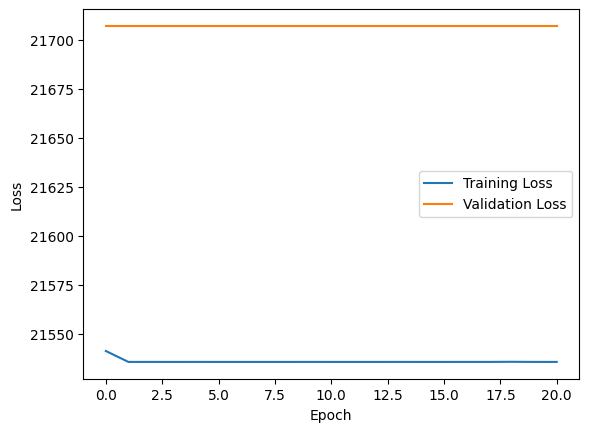

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

input_layer = layers.Input(shape=(2400,))

# Dense layers
# dense1 = layers.Dense(2048, activation='relu')(input_layer)
# dropout1 = layers.Dropout(0.2)(dense1)

# dense2 = layers.Dense(1024, activation='relu')(dropout1)
# dropout2 = layers.Dropout(0.2)(dense2)

# dense3 = layers.Dense(512, activation='relu')(dropout2)
# dropout3 = layers.Dropout(0.2)(dense3)

dense4 = layers.Dense(256, activation='relu')(input_layer)
dropout4 = layers.Dropout(0.2)(dense4)

dense5 = layers.Dense(128, activation='relu')(dropout4)
dropout5 = layers.Dropout(0.2)(dense5)

dense6 = layers.Dense(64, activation='relu')(dropout5)
dropout6 = layers.Dropout(0.2)(dense6)

# Output layer
output_layer = layers.Dense(4, activation='tanh')(dropout6)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=500, batch_size=8,
                    validation_split=0.2, callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(X_test)
mse_scaled = mean_squared_error(y_test, predictions)
print("Scaled test error", mse_scaled)

5/5 [==============================] - 0s 5ms/step
Scaled test error 0.0138458929834607


In [ ]:
y_test_is = inverse_transform_labels(y_test)
predictions = inverse_transform_labels(predictions)
mse = mean_squared_error(y_test_is, predictions)
print("mse", mse)

mse 1664.6722339431062


In [ ]:
from sklearn.metrics import mean_absolute_error

# Assuming y_test_is and predictions are your actual and predicted values
mae = mean_absolute_error(y_test_is, predictions)

print("MAE:", mae)

MAE: 25.07258378967872


In [ ]:
mape = np.mean(np.abs((y_test_is[:,0] - predictions[:,0]) / y_test_is[:,0])) * 100

print("MAPE:", mape)

MAPE: 39.72187440398348


In [ ]:
mse ** 0.5

40.80039502190029